In [1]:
import librosa
from librosa.feature import melspectrogram
from librosa.core import load
from librosa.display import specshow
from librosa import power_to_db
import random

import matplotlib.pyplot as plt

In [2]:
import os
from tqdm import tqdm
import pickle
import pandas as pd
import numpy as np

from librosa.feature import melspectrogram
from librosa.core import load as load_wav
from librosa import power_to_db


def extract_log_mel_feats(set_type, path_to_csv, path_to_files, out_path, sr, fft_size, hop, n_mels):
    """
    Extract features from given files and store them in binary format.

    :param set_type:
    :param path_to_csv: path to loaded csv
    :param path_to_files: path to loaded data
    :param out_path: path to store extracted features
    :param sr: input files sample rate
    :param fft_size: size of fft window
    :param hop: hop size
    :param n_mels: number of mel band

    :return:

    """
    set_type = set_type.lower()
    if set_type not in ['train', 'test']:
        raise Exception('Such set type not supported: {}'.format(set_type))

    feats = []

    if set_type == 'train':
        meta = pd.read_csv(path_to_csv, skiprows=1, names=['fname', 'label', 'manually_verified'])

        file_names = list(meta['fname'])
        n_files = len(file_names)
        labels = list(meta['label'])

        uniq_labels = np.sort(np.unique(labels))
        label_to_id = {label: i for i, label in enumerate(uniq_labels)}

        print('Total files:', n_files)

        for i, (file_name, label) in tqdm(enumerate(zip(file_names, labels))):
            wav_data, sr = load_wav(os.path.join(path_to_files, file_name), sr=sr)
            mel_spec = melspectrogram(y=wav_data, n_fft=fft_size, hop_length=hop, n_mels=n_mels, fmax=sr // 2)
            log_mel_spec = power_to_db(mel_spec, ref=np.max)
            feats.append({
                'fname': file_name,
                'feature': log_mel_spec,
                'label_id': label_to_id[label]
            })
        pickle.dump(feats, open(out_path, 'wb'))    
        return label_to_id
    else:
        for i, file_name in tqdm(enumerate(os.listdir(path_to_files))):
            wav_data, sr = load_wav(os.path.join(path_to_files, file_name), sr=sr)
            if len(wav_data) == 0:
                # print('Empty file:', file_name)
                wav_data = np.zeros(sr)
            mel_spec = melspectrogram(wav_data, n_fft=fft_size, n_mels=n_mels, fmax=sr // 2)
            log_mel_spec = power_to_db(mel_spec, ref=np.max)
            feats.append({
                'fname': file_name,
                'feature': log_mel_spec,
            })

    pickle.dump(feats, open(out_path, 'wb'))

In [3]:
# For kaggle
# PATH = '/kaggle/input/audio-train-for-aed-lab/'
PATH = ''

In [4]:
train_folder = PATH + 'train/'
# train_folder = './data/audio_train/'
# test_folder = './data/audio_test/'

sample_rate = 11025
fft_size = 1024
overlap = 4
hop = fft_size // overlap
mels = 64

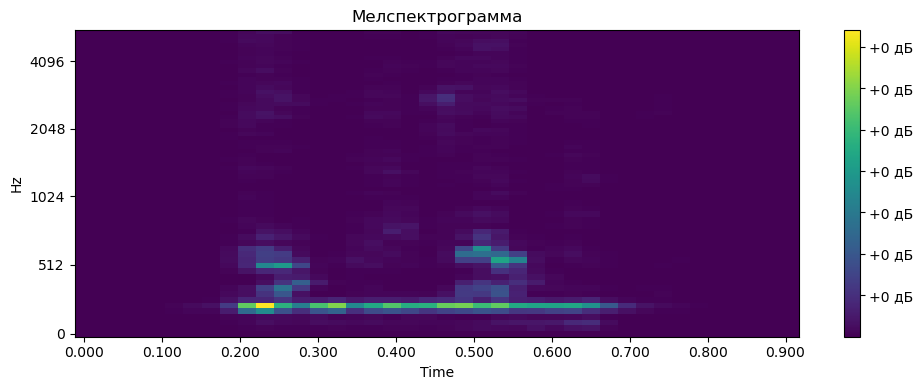

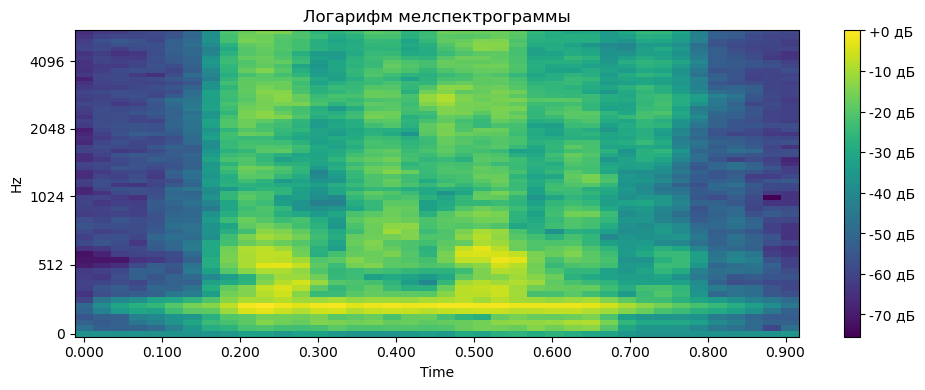

In [5]:
wav_data, sr = load(os.path.join(train_folder, random.choice(os.listdir(train_folder))), sr=sample_rate)
mel_spec = melspectrogram(y=wav_data, n_fft=fft_size, hop_length=hop, n_mels=mels, 
                          fmax=sample_rate//2)

plt.figure(figsize=(10, 4))
colors = 'viridis'
specshow(mel_spec, y_axis='mel', fmax=sample_rate//2, x_axis='time', cmap=colors)
plt.colorbar(format='%+2.0f дБ')
plt.title('Мелспектрограмма')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
specshow(power_to_db(mel_spec, ref=np.max), y_axis='mel',
         fmax=sample_rate//2, x_axis='time', cmap=colors)
plt.colorbar(format='%+2.0f дБ')
plt.title('Логарифм мелспектрограммы')
plt.tight_layout()
plt.show()

In [6]:
# path_to_csv = os.path.join('./data', 'train.csv')

path_to_csv = PATH + 'train.csv'

pickle_train_path = os.path.join('train.pickle')
# pickle_test_path = os.path.join('./data', 'test.pickle')

label_to_id = extract_log_mel_feats('train', path_to_csv, train_folder, pickle_train_path, sample_rate, fft_size, hop, mels)
id_to_label = [label for label, i in label_to_id.items()]

# extract_log_mel_feats('test', '', test_folder, pickle_test_path, sample_rate, fft_size, hop, mels)

Total files: 5683


5683it [03:27, 27.34it/s]


In [7]:
import numpy as np
import pandas as pd
import soundfile as sf
import torch.nn.functional as F
import torch.nn as nn
import torch


class DummyNetwork(nn.Module):
    def __init__(self, device = None):
        super(DummyNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, stride=(2, 2), device=device)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, stride=(1, 1), device=device)
        self.conv3 = nn.Conv2d(in_channels=96, out_channels=64, kernel_size=3, stride=(1, 1), device=device)
        
        self.mp = nn.MaxPool2d(kernel_size=(2, 2), stride=(1, 1))
        
        self.dropout1 = nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.3)
        self.dropout3 = nn.Dropout(p=0.3)
        
        self.bn1 = nn.BatchNorm2d(num_features=64, device=device)
        self.bn2 = nn.BatchNorm2d(num_features=96, device=device)
        self.bn3 = nn.BatchNorm2d(num_features=64, device=device)
        
        self.flat = nn.Flatten()
        
        # 33856 - должно соответствовать форме self.flat
        self.fc1 = nn.Linear(33856, 41, device=device)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout3(x)
        
        x = self.flat(x)
        # здесь можно еще добавить полносвязных слой или слои
        x = self.fc1(x)
        return x


In [8]:
device = device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [9]:
cpu_count = os.cpu_count()

num_workers = cpu_count if device == "cpu" else 0
num_workers, cpu_count

(0, 2)

In [10]:
def set_random_state(random_state = 0):
    """Initialize random generators.

    Parameters
    ==========
    random_state : int = 0
        Determines random number generation for centroid initialization.
        Use an int to make the randomness deterministic.
    """
    torch.manual_seed(random_state)
    random.seed(random_state)
    np.random.seed(random_state)

    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(random_state)
        torch.cuda.manual_seed(random_state)

        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [11]:
random_state = 42

set_random_state(random_state)

torch.use_deterministic_algorithms(True)

%env CUBLAS_WORKSPACE_CONFIG=:4096:8
%env PYTHONHASHSEED=42

random_input = torch.randn(1, 1, 64, 64, requires_grad=True, device=device)
network = DummyNetwork(device=device)
output = network(random_input)
print(output)

env: CUBLAS_WORKSPACE_CONFIG=:4096:8
env: PYTHONHASHSEED=42
tensor([[-2.0144e-01, -2.1711e-01,  6.8479e-01, -1.2975e-03,  7.8605e-01,
         -2.4199e-01,  3.5977e-01,  1.1469e+00, -9.1528e-01, -5.6117e-01,
         -3.7027e-01, -3.6648e-01,  1.7319e+00,  5.1950e-01, -3.5113e-01,
          7.2721e-02, -2.9235e-02, -1.2073e-01, -2.9459e-01,  3.2928e-01,
         -9.3407e-03,  5.4718e-01,  3.7316e-02,  5.7438e-01, -4.5652e-01,
          4.6992e-01, -6.3313e-01,  1.4175e+00, -1.3361e+00,  1.6777e-01,
         -9.6763e-01,  5.8675e-02, -3.2045e-01,  7.4528e-01,  6.9956e-01,
          9.5195e-02,  2.8379e-01, -4.7728e-01,  6.6330e-01, -6.6214e-01,
          3.1636e-01]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [12]:
import torch.optim as optim


criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(network.parameters(), lr=0.001)
optimizer.zero_grad()

random_input = torch.randn(3, 1, 64, 64, requires_grad=True, device=device)

output = network(random_input)
target = torch.empty(3, dtype=torch.long, device=device).random_(5)

loss = criterion(output, target)

print(loss.item())

loss.backward()
optimizer.step() 

4.4389328956604


In [13]:
import pickle

pickle_train_data = pickle.load(open(pickle_train_path, 'rb'))

In [14]:
def prepare_shape(feature):
    tmp = feature
    N = 64 # размер во времени (можно увеличить, должно стать лучше)
    while tmp.shape[1] < N:
        # можно попробовать сделать np.pad для коротких файлов, вместо повторения до необходимой длины
        tmp = np.hstack((tmp, tmp))
    # случайный сдвиг должен улучшить результат (для этого нужно функцию перенести в EventDetectionDataset)
    tmp = tmp[np.newaxis, :, :N]
    return tmp

In [15]:
# можно улучшить, используя сбалансированное валидационное множество
# гуглить stratified train test split sklearn
validation_set_size = 800

x_val = []
y_val = []

x_tr = []
y_tr = []

for i, row in enumerate(pickle_train_data):
    feature = prepare_shape(row['feature'])
    if i < validation_set_size:
        x_val.append(feature)
        y_val.append(row['label_id'])
    else:
        x_tr.append(feature)
        y_tr.append(row['label_id'])
x_val = np.asarray(x_val)
x_tr = np.asarray(x_tr)

y_val = np.asarray(y_val)
y_tr = np.asarray(y_tr)

In [16]:
from torch.utils.data import Dataset


class EventDetectionDataset(Dataset):
    def __init__(self, x, y=None, device=None):
        self.x = x
        self.y = y

        self.device = device
    
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        # добавить сюда prepare_shape()
        if self.y is not None:
            return torch.tensor(self.x[idx], device=self.device), torch.tensor(self.y[idx], device=self.device)
        return torch.tensor(self.x[idx], device=self.device)

In [17]:
train_dset = EventDetectionDataset(x_tr, y_tr, device)
val_dset = EventDetectionDataset(x_val, y_val, device)

In [18]:
sample_x, sample_y = random.choice(val_dset)

sample_y.item(), id_to_label[sample_y]

(10, 'Cough')

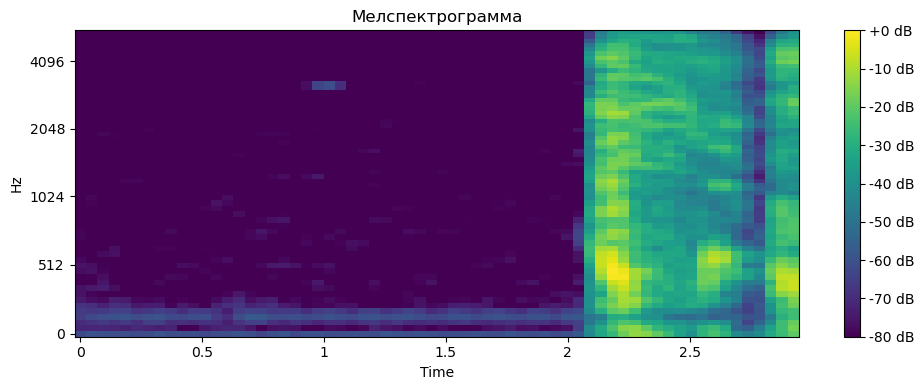

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
cmap = "viridis"

img = librosa.display.specshow(
    sample_x[0].numpy(force=True),
    sr=sample_rate,
    fmax=sample_rate // 2,
    ax=ax,
    x_axis='time',
    y_axis='mel',
    cmap=cmap,
)
ax.set(title='Мелспектрограмма')
ax.label_outer()

fig.colorbar(img, ax=ax, format="%+2.f dB")
plt.tight_layout()
plt.show()

In [20]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dset, batch_size=41, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dset, batch_size=41, shuffle=False, num_workers=num_workers)

In [21]:
from sklearn.metrics import accuracy_score

epoch # 0
mean train loss: 3.464339246352514
train accuracy: 0.1255375793569527
mean val loss: 5.767963433265686
val accuracy: 0.07375
epoch # 1
mean train loss: 2.9174938082695006
train accuracy: 0.2199467540446447
mean val loss: 4.424973034858704
val accuracy: 0.12125
epoch # 2
mean train loss: 2.6517832477887473
train accuracy: 0.27585500716772476
mean val loss: 6.808448934555054
val accuracy: 0.04125
epoch # 3
mean train loss: 2.5276278495788573
train accuracy: 0.320499692811796
mean val loss: 4.196096277236938
val accuracy: 0.11375
epoch # 4
mean train loss: 2.382522848248482
train accuracy: 0.3428220356338317
mean val loss: 3.8830851793289183
val accuracy: 0.155
epoch # 5
mean train loss: 2.261935235063235
train accuracy: 0.3817325414704075
mean val loss: 4.2677826404571535
val accuracy: 0.12375
epoch # 6
mean train loss: 2.166132860382398
train accuracy: 0.4028261314765513
mean val loss: 3.1629598498344422
val accuracy: 0.20875
epoch # 7
mean train loss: 2.095519193013509
train 

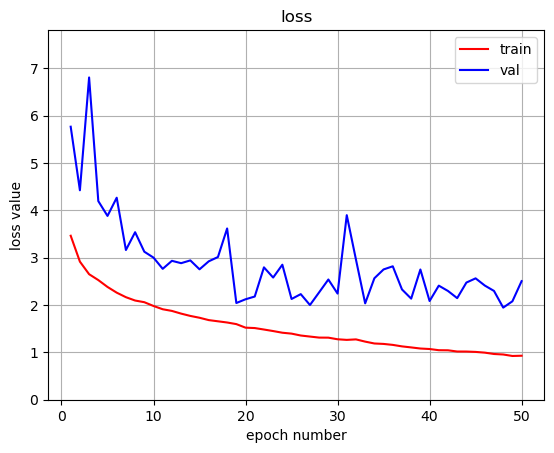

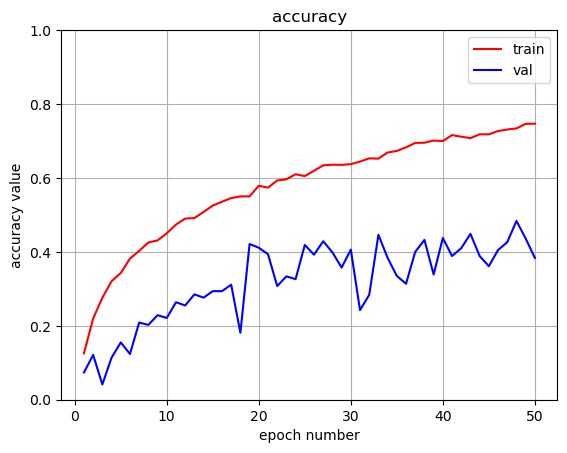

In [22]:
n_epoch = 50
criterion = nn.CrossEntropyLoss()
network = DummyNetwork(device=device)
optimizer = optim.SGD(network.parameters(), lr=0.001)

train_loss = []
val_loss = []

train_acc = []
val_acc = []

for e in range(n_epoch):
    print('epoch #', e)
    # train
    loss_list = []
    outputs = []
    targets = []
    for i_batch, sample_batched in enumerate(train_loader):
        x, y = sample_batched
        optimizer.zero_grad()

        output = network(x)
        outputs.append(output.argmax(axis=1))
    
        target = y
        targets.append(target)
        
        loss = criterion(output, target.long())
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
    y_true = torch.hstack(targets).numpy(force=True)
    y_pred = torch.hstack(outputs).numpy(force=True)
    acc = accuracy_score(y_true, y_pred)
    train_loss.append(np.mean(loss_list))
    train_acc.append(acc)
    print('mean train loss:', train_loss[-1])
    print('train accuracy:', acc)
    
    
    loss_list = []
    outputs = []
    targets = []
    with torch.no_grad():
        for i_batch, sample_batched in enumerate(val_loader):
            x, y = sample_batched
#             optimizer.zero_grad()

            output = network(x)
            outputs.append(output.argmax(axis=1))

            target = y
            targets.append(target)

            loss = criterion(output, target.long())
            loss_list.append(loss.item())
#             loss.backward()
#             optimizer.step()
            
        y_true = torch.hstack(targets).numpy(force=True)
        y_pred = torch.hstack(outputs).numpy(force=True)
        acc = accuracy_score(y_true, y_pred)
        val_loss.append(np.mean(loss_list))
        val_acc.append(acc)
        print('mean val loss:', val_loss[-1])
        print('val accuracy:', acc)




epochs = np.arange(1, n_epoch+1)

axes = plt.gca()
axes.set_ylim([0,max(max(train_loss), max(val_loss))+1])
plt.plot(epochs, train_loss, 'r', label='train')
plt.plot(epochs, val_loss, 'b', label='val')
plt.title('loss')
plt.xlabel('epoch number')
plt.ylabel('loss value')
plt.legend()
plt.grid()
plt.show()


axes = plt.gca()
axes.set_ylim([0,1])
plt.plot(epochs, train_acc, 'r', label='train')
plt.plot(epochs, val_acc, 'b', label='val')
plt.title('accuracy')
plt.xlabel('epoch number')
plt.ylabel('accuracy value')
plt.legend()
plt.grid()
plt.show()

Изменение количества эпох до 150

epoch # 0
mean train loss: 3.45362090865771
train accuracy: 0.12697112430882654
mean val loss: 5.550210165977478
val accuracy: 0.0925
epoch # 1
mean train loss: 2.9249362349510193
train accuracy: 0.21257423714929347
mean val loss: 4.307110702991485
val accuracy: 0.06625
epoch # 2
mean train loss: 2.6748347798983256
train accuracy: 0.27790292852754456
mean val loss: 4.0165278792381285
val accuracy: 0.135
epoch # 3
mean train loss: 2.5123203535874685
train accuracy: 0.31087446242064304
mean val loss: 3.357341134548187
val accuracy: 0.175
epoch # 4
mean train loss: 2.370339995622635
train accuracy: 0.36043415932828177
mean val loss: 4.323099744319916
val accuracy: 0.1325
epoch # 5
mean train loss: 2.279779013991356
train accuracy: 0.377636698750768
mean val loss: 3.98447003364563
val accuracy: 0.13375
epoch # 6
mean train loss: 2.200373270114263
train accuracy: 0.396067990989146
mean val loss: 3.577891194820404
val accuracy: 0.1825
epoch # 7
mean train loss: 2.1317089875539144
train accur

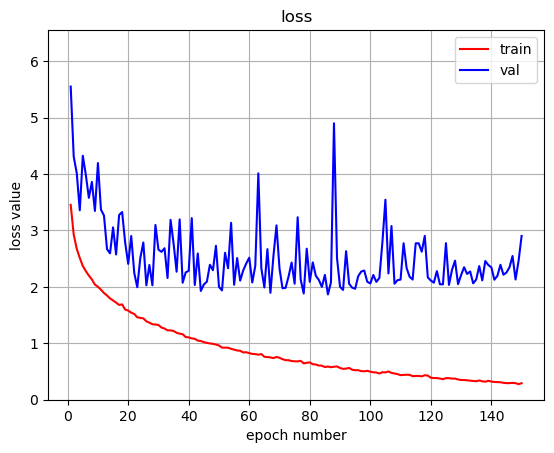

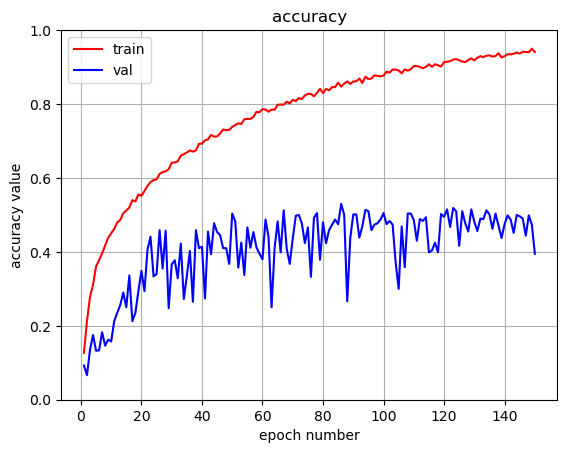

In [23]:
n_epoch = 150
criterion = nn.CrossEntropyLoss()
network = DummyNetwork(device=device)
# можно попробовать другой optimizer, тоже считается улучшением
optimizer = optim.SGD(network.parameters(), lr=0.001)

train_loss = []
val_loss = []

train_acc = []
val_acc = []

for e in range(n_epoch):
    print('epoch #', e)
    # train
    loss_list = []
    outputs = []
    targets = []
    for i_batch, sample_batched in enumerate(train_loader):
        x, y = sample_batched
        optimizer.zero_grad()

        output = network(x)
        outputs.append(output.argmax(axis=1))
    
        target = y
        targets.append(target)
        
        loss = criterion(output, target.long())
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
    y_true = torch.hstack(targets).numpy(force=True)
    y_pred = torch.hstack(outputs).numpy(force=True)
    acc = accuracy_score(y_true, y_pred)
    train_loss.append(np.mean(loss_list))
    train_acc.append(acc)
    print('mean train loss:', train_loss[-1])
    print('train accuracy:', acc)
    
    
    loss_list = []
    outputs = []
    targets = []
    with torch.no_grad():
        for i_batch, sample_batched in enumerate(val_loader):
            x, y = sample_batched
#             optimizer.zero_grad()

            output = network(x)
            outputs.append(output.argmax(axis=1))

            target = y
            targets.append(target)

            loss = criterion(output, target.long())
            loss_list.append(loss.item())
#             loss.backward()
#             optimizer.step()
            
        y_true = torch.hstack(targets).numpy(force=True)
        y_pred = torch.hstack(outputs).numpy(force=True)
        acc = accuracy_score(y_true, y_pred)
        val_loss.append(np.mean(loss_list))
        val_acc.append(acc)
        print('mean val loss:', val_loss[-1])
        print('val accuracy:', acc)



epochs = np.arange(1, n_epoch+1)

axes = plt.gca()
axes.set_ylim([0,max(max(train_loss), max(val_loss))+1])
plt.plot(epochs, train_loss, 'r', label='train')
plt.plot(epochs, val_loss, 'b', label='val')
plt.title('loss')
plt.xlabel('epoch number')
plt.ylabel('loss value')
plt.legend()
plt.grid()
plt.show()


axes = plt.gca()
axes.set_ylim([0,1])
plt.plot(epochs, train_acc, 'r', label='train')
plt.plot(epochs, val_acc, 'b', label='val')
plt.title('accuracy')
plt.xlabel('epoch number')
plt.ylabel('accuracy value')
plt.legend()
plt.grid()
plt.show()

Изменение оптимизатора со стозастического градиентного спуска на AdamW

epoch # 0
mean train loss: 9.738768291473388
train accuracy: 0.1347532254761417
mean val loss: 5.945864629745484
val accuracy: 0.155
epoch # 1
mean train loss: 4.660268839200338
train accuracy: 0.2396067990989146
mean val loss: 4.901321446895599
val accuracy: 0.2125
epoch # 2
mean train loss: 3.941904616355896
train accuracy: 0.29408150727012083
mean val loss: 3.743958628177643
val accuracy: 0.29625
epoch # 3
mean train loss: 2.9428522686163583
train accuracy: 0.3653491705918493
mean val loss: 3.046313667297363
val accuracy: 0.32375
epoch # 4
mean train loss: 2.601093164086342
train accuracy: 0.41101781691583045
mean val loss: 3.050226938724518
val accuracy: 0.315
epoch # 5
mean train loss: 1.998262236515681
train accuracy: 0.4775752611099734
mean val loss: 2.4230781972408293
val accuracy: 0.40375
epoch # 6
mean train loss: 1.8642342875401179
train accuracy: 0.5158713905386033
mean val loss: 2.2449164390563965
val accuracy: 0.40875
epoch # 7
mean train loss: 1.6310930420955023
train ac

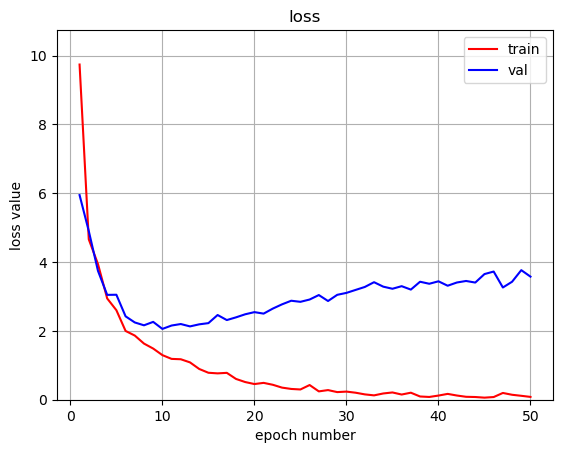

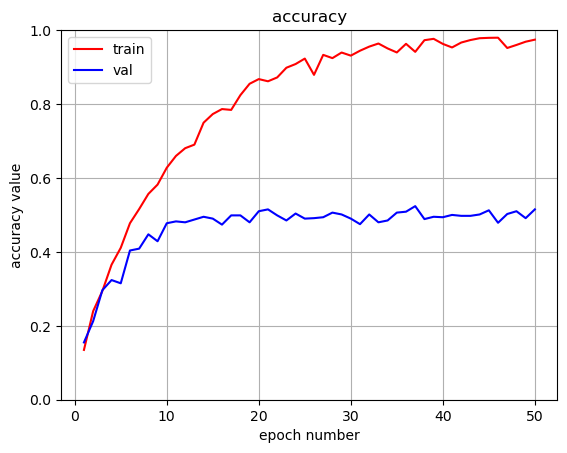

In [24]:
n_epoch = 50
criterion = nn.CrossEntropyLoss()
network = DummyNetwork(device=device)
# можно попробовать другой optimizer, тоже считается улучшением
optimizer = optim.AdamW(network.parameters())

train_loss = []
val_loss = []

train_acc = []
val_acc = []

for e in range(n_epoch):
    print('epoch #', e)
    # train
    loss_list = []
    outputs = []
    targets = []
    for i_batch, sample_batched in enumerate(train_loader):
        x, y = sample_batched
        optimizer.zero_grad()

        output = network(x)
        outputs.append(output.argmax(axis=1))
    
        target = y
        targets.append(target)
        
        loss = criterion(output, target.long())
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
    y_true = torch.hstack(targets).numpy(force=True)
    y_pred = torch.hstack(outputs).numpy(force=True)
    acc = accuracy_score(y_true, y_pred)
    train_loss.append(np.mean(loss_list))
    train_acc.append(acc)
    print('mean train loss:', train_loss[-1])
    print('train accuracy:', acc)
    
    
    loss_list = []
    outputs = []
    targets = []
    with torch.no_grad():
        for i_batch, sample_batched in enumerate(val_loader):
            x, y = sample_batched
#             optimizer.zero_grad()

            output = network(x)
            outputs.append(output.argmax(axis=1))

            target = y
            targets.append(target)

            loss = criterion(output, target.long())
            loss_list.append(loss.item())
#             loss.backward()
#             optimizer.step()
            
        y_true = torch.hstack(targets).numpy(force=True)
        y_pred = torch.hstack(outputs).numpy(force=True)
        acc = accuracy_score(y_true, y_pred)
        val_loss.append(np.mean(loss_list))
        val_acc.append(acc)
        print('mean val loss:', val_loss[-1])
        print('val accuracy:', acc)



epochs = np.arange(1, n_epoch+1)

axes = plt.gca()
axes.set_ylim([0,max(max(train_loss), max(val_loss))+1])
plt.plot(epochs, train_loss, 'r', label='train')
plt.plot(epochs, val_loss, 'b', label='val')
plt.title('loss')
plt.xlabel('epoch number')
plt.ylabel('loss value')
plt.legend()
plt.grid()
plt.show()


axes = plt.gca()
axes.set_ylim([0,1])
plt.plot(epochs, train_acc, 'r', label='train')
plt.plot(epochs, val_acc, 'b', label='val')
plt.title('accuracy')
plt.xlabel('epoch number')
plt.ylabel('accuracy value')
plt.legend()
plt.grid()
plt.show()

In [25]:
from sklearn.model_selection import StratifiedShuffleSplit

features = [row['feature'] for i, row in enumerate(pickle_train_data)]
labels = [row['label_id'] for i, row in enumerate(pickle_train_data)]

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=random_state)
# train_indices, val_indices = sss.split(features, labels)
splt = list(sss.split(features, labels))
train_indices, val_indices = splt[0][0], splt[0][1]


x_val = []
y_val = []

x_tr = []
y_tr = []

for i, row in enumerate(pickle_train_data):
    feature = prepare_shape(row['feature'])
    if i in train_indices:
        x_val.append(feature)
        y_val.append(row['label_id'])
    else:
        x_tr.append(feature)
        y_tr.append(row['label_id'])
x_val = np.asarray(x_val)
x_tr = np.asarray(x_tr)

y_val = np.asarray(y_val)
y_tr = np.asarray(y_tr)


train_dset = EventDetectionDataset(x_tr, y_tr, device)
val_dset = EventDetectionDataset(x_val, y_val, device)

train_loader = DataLoader(train_dset, batch_size=41, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dset, batch_size=41, shuffle=False, num_workers=num_workers)

epoch # 0
mean train loss: 3.8565658586365834
train accuracy: 0.05364995602462621
mean val loss: 3.573370699409966
val accuracy: 0.08534975802903652
epoch # 1
mean train loss: 3.3570670826094493
train accuracy: 0.12576956904133685
mean val loss: 3.51681163504317
val accuracy: 0.10690717113946327
epoch # 2
mean train loss: 3.1278779336384366
train accuracy: 0.16094986807387862
mean val loss: 3.2723686351432457
val accuracy: 0.15222173339199296
epoch # 3
mean train loss: 2.8778388585363115
train accuracy: 0.23746701846965698
mean val loss: 3.24307073558773
val accuracy: 0.16300043994720634
epoch # 4
mean train loss: 2.730986407824925
train accuracy: 0.24274406332453827
mean val loss: 3.1523863130861574
val accuracy: 0.19973603167619886
epoch # 5
mean train loss: 2.597306932721819
train accuracy: 0.28935795954265614
mean val loss: 3.155440680615537
val accuracy: 0.17773867135943686
epoch # 6
mean train loss: 2.4624802129609242
train accuracy: 0.3254177660510114
mean val loss: 3.0696329640

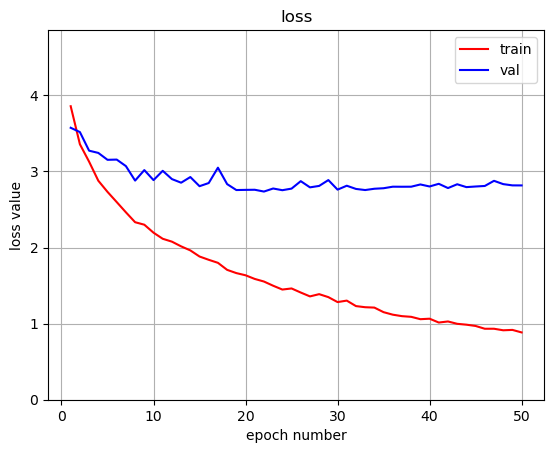

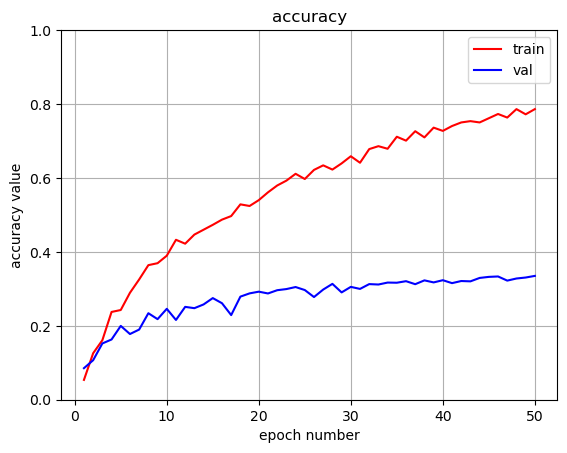

In [26]:
n_epoch = 50
criterion = nn.CrossEntropyLoss()
network = DummyNetwork(device=device)
optimizer = optim.SGD(network.parameters(), lr=0.001)

train_loss = []
val_loss = []

train_acc = []
val_acc = []

for e in range(n_epoch):
    print('epoch #', e)
    # train
    loss_list = []
    outputs = []
    targets = []
    for i_batch, sample_batched in enumerate(train_loader):
        x, y = sample_batched
        optimizer.zero_grad()

        output = network(x)
        outputs.append(output.argmax(axis=1))
    
        target = y
        targets.append(target)
        
        loss = criterion(output, target.long())
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
    y_true = torch.hstack(targets).numpy(force=True)
    y_pred = torch.hstack(outputs).numpy(force=True)
    acc = accuracy_score(y_true, y_pred)
    train_loss.append(np.mean(loss_list))
    train_acc.append(acc)
    print('mean train loss:', train_loss[-1])
    print('train accuracy:', acc)
    
    
    loss_list = []
    outputs = []
    targets = []
    with torch.no_grad():
        for i_batch, sample_batched in enumerate(val_loader):
            x, y = sample_batched
#             optimizer.zero_grad()

            output = network(x)
            outputs.append(output.argmax(axis=1))

            target = y
            targets.append(target)

            loss = criterion(output, target.long())
            loss_list.append(loss.item())
#             loss.backward()
#             optimizer.step()
            
        y_true = torch.hstack(targets).numpy(force=True)
        y_pred = torch.hstack(outputs).numpy(force=True)
        acc = accuracy_score(y_true, y_pred)
        val_loss.append(np.mean(loss_list))
        val_acc.append(acc)
        print('mean val loss:', val_loss[-1])
        print('val accuracy:', acc)




epochs = np.arange(1, n_epoch+1)

axes = plt.gca()
axes.set_ylim([0,max(max(train_loss), max(val_loss))+1])
plt.plot(epochs, train_loss, 'r', label='train')
plt.plot(epochs, val_loss, 'b', label='val')
plt.title('loss')
plt.xlabel('epoch number')
plt.ylabel('loss value')
plt.legend()
plt.grid()
plt.show()


axes = plt.gca()
axes.set_ylim([0,1])
plt.plot(epochs, train_acc, 'r', label='train')
plt.plot(epochs, val_acc, 'b', label='val')
plt.title('accuracy')
plt.xlabel('epoch number')
plt.ylabel('accuracy value')
plt.legend()
plt.grid()
plt.show()

epoch # 0
mean train loss: 4.11012681041445
train accuracy: 0.055408970976253295
mean val loss: 3.817738526576274
val accuracy: 0.08490981082270127
epoch # 1
mean train loss: 3.345656590802329
train accuracy: 0.15127528583992964
mean val loss: 3.3694835976437405
val accuracy: 0.11526616805983282
epoch # 2
mean train loss: 3.093670972755977
train accuracy: 0.1662269129287599
mean val loss: 3.218219501478178
val accuracy: 0.17927848658161022
epoch # 3
mean train loss: 2.881716089589255
train accuracy: 0.21723834652594548
mean val loss: 3.1159977053736783
val accuracy: 0.1869775626924769
epoch # 4
mean train loss: 2.7714881896972656
train accuracy: 0.24714160070360597
mean val loss: 3.078402755496738
val accuracy: 0.17949846018477783
epoch # 5
mean train loss: 2.6085324628012523
train accuracy: 0.29815303430079154
mean val loss: 3.02140474319458
val accuracy: 0.2166739991201056
epoch # 6
mean train loss: 2.4798359956060136
train accuracy: 0.3438874230430959
mean val loss: 3.06749799874451

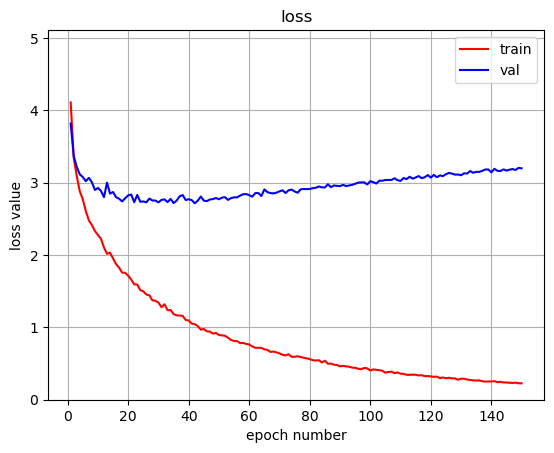

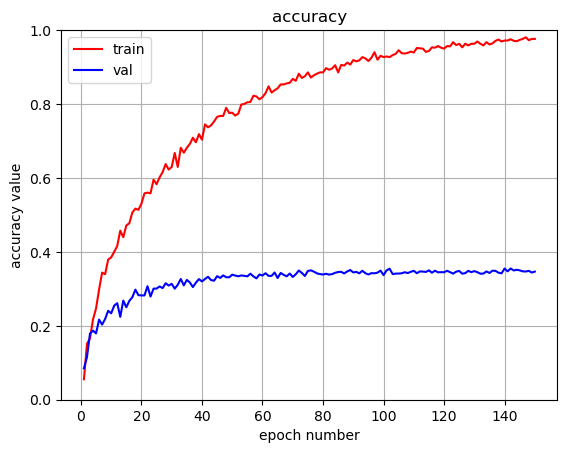

In [27]:
n_epoch = 150
criterion = nn.CrossEntropyLoss()
network = DummyNetwork(device=device)
# можно попробовать другой optimizer, тоже считается улучшением
optimizer = optim.SGD(network.parameters(), lr=0.001)

train_loss = []
val_loss = []

train_acc = []
val_acc = []

for e in range(n_epoch):
    print('epoch #', e)
    # train
    loss_list = []
    outputs = []
    targets = []
    for i_batch, sample_batched in enumerate(train_loader):
        x, y = sample_batched
        optimizer.zero_grad()

        output = network(x)
        outputs.append(output.argmax(axis=1))
    
        target = y
        targets.append(target)
        
        loss = criterion(output, target.long())
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
    y_true = torch.hstack(targets).numpy(force=True)
    y_pred = torch.hstack(outputs).numpy(force=True)
    acc = accuracy_score(y_true, y_pred)
    train_loss.append(np.mean(loss_list))
    train_acc.append(acc)
    print('mean train loss:', train_loss[-1])
    print('train accuracy:', acc)
    
    
    loss_list = []
    outputs = []
    targets = []
    with torch.no_grad():
        for i_batch, sample_batched in enumerate(val_loader):
            x, y = sample_batched
#             optimizer.zero_grad()

            output = network(x)
            outputs.append(output.argmax(axis=1))

            target = y
            targets.append(target)

            loss = criterion(output, target.long())
            loss_list.append(loss.item())
#             loss.backward()
#             optimizer.step()
            
        y_true = torch.hstack(targets).numpy(force=True)
        y_pred = torch.hstack(outputs).numpy(force=True)
        acc = accuracy_score(y_true, y_pred)
        val_loss.append(np.mean(loss_list))
        val_acc.append(acc)
        print('mean val loss:', val_loss[-1])
        print('val accuracy:', acc)



epochs = np.arange(1, n_epoch+1)

axes = plt.gca()
axes.set_ylim([0,max(max(train_loss), max(val_loss))+1])
plt.plot(epochs, train_loss, 'r', label='train')
plt.plot(epochs, val_loss, 'b', label='val')
plt.title('loss')
plt.xlabel('epoch number')
plt.ylabel('loss value')
plt.legend()
plt.grid()
plt.show()


axes = plt.gca()
axes.set_ylim([0,1])
plt.plot(epochs, train_acc, 'r', label='train')
plt.plot(epochs, val_acc, 'b', label='val')
plt.title('accuracy')
plt.xlabel('epoch number')
plt.ylabel('accuracy value')
plt.legend()
plt.grid()
plt.show()

epoch # 0
mean train loss: 19.941345470292227
train accuracy: 0.06772207563764292
mean val loss: 10.245184902672294
val accuracy: 0.1194456665200176
epoch # 1
mean train loss: 7.047936047826495
train accuracy: 0.16886543535620052
mean val loss: 7.214683476869051
val accuracy: 0.14562252529696437
epoch # 2
mean train loss: 4.929103783198765
train accuracy: 0.2260334212840809
mean val loss: 7.082402233604912
val accuracy: 0.1491421029476463
epoch # 3
mean train loss: 4.620582376207624
train accuracy: 0.2620932277924362
mean val loss: 5.794033048389195
val accuracy: 0.19423669159700835
epoch # 4
mean train loss: 3.850734923567091
train accuracy: 0.31574318381706246
mean val loss: 5.752853726481532
val accuracy: 0.2135943686757589
epoch # 5
mean train loss: 3.428954073360988
train accuracy: 0.3685136323658751
mean val loss: 5.503721514263669
val accuracy: 0.2069951605807303
epoch # 6
mean train loss: 3.153098770550319
train accuracy: 0.3808267370272647
mean val loss: 5.334888097402212
val 

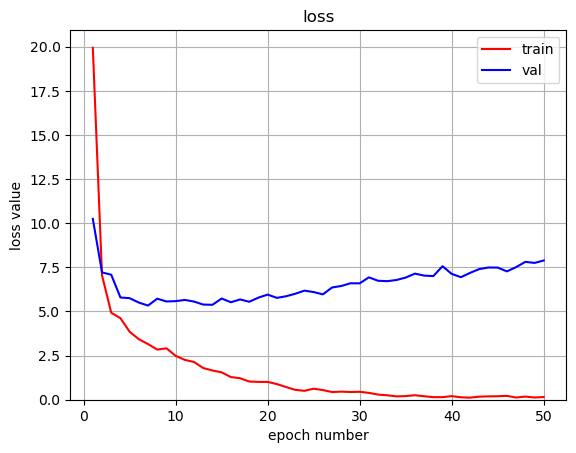

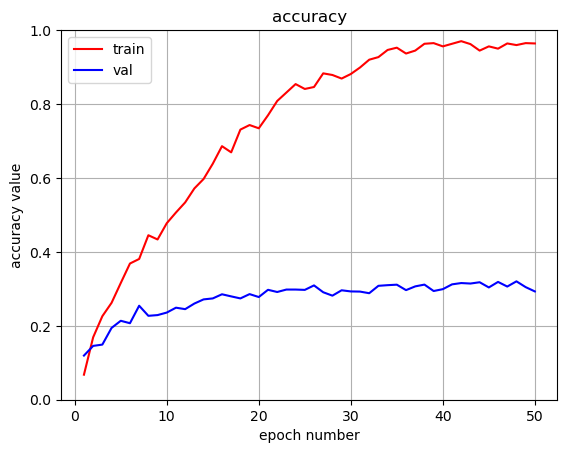

In [28]:
n_epoch = 50
criterion = nn.CrossEntropyLoss()
network = DummyNetwork(device=device)
# можно попробовать другой optimizer, тоже считается улучшением
optimizer = optim.AdamW(network.parameters())

train_loss = []
val_loss = []

train_acc = []
val_acc = []

for e in range(n_epoch):
    print('epoch #', e)
    # train
    loss_list = []
    outputs = []
    targets = []
    for i_batch, sample_batched in enumerate(train_loader):
        x, y = sample_batched
        optimizer.zero_grad()

        output = network(x)
        outputs.append(output.argmax(axis=1))
    
        target = y
        targets.append(target)
        
        loss = criterion(output, target.long())
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
    y_true = torch.hstack(targets).numpy(force=True)
    y_pred = torch.hstack(outputs).numpy(force=True)
    acc = accuracy_score(y_true, y_pred)
    train_loss.append(np.mean(loss_list))
    train_acc.append(acc)
    print('mean train loss:', train_loss[-1])
    print('train accuracy:', acc)
    
    
    loss_list = []
    outputs = []
    targets = []
    with torch.no_grad():
        for i_batch, sample_batched in enumerate(val_loader):
            x, y = sample_batched
#             optimizer.zero_grad()

            output = network(x)
            outputs.append(output.argmax(axis=1))

            target = y
            targets.append(target)

            loss = criterion(output, target.long())
            loss_list.append(loss.item())
#             loss.backward()
#             optimizer.step()
            
        y_true = torch.hstack(targets).numpy(force=True)
        y_pred = torch.hstack(outputs).numpy(force=True)
        acc = accuracy_score(y_true, y_pred)
        val_loss.append(np.mean(loss_list))
        val_acc.append(acc)
        print('mean val loss:', val_loss[-1])
        print('val accuracy:', acc)



epochs = np.arange(1, n_epoch+1)

axes = plt.gca()
axes.set_ylim([0,max(max(train_loss), max(val_loss))+1])
plt.plot(epochs, train_loss, 'r', label='train')
plt.plot(epochs, val_loss, 'b', label='val')
plt.title('loss')
plt.xlabel('epoch number')
plt.ylabel('loss value')
plt.legend()
plt.grid()
plt.show()


axes = plt.gca()
axes.set_ylim([0,1])
plt.plot(epochs, train_acc, 'r', label='train')
plt.plot(epochs, val_acc, 'b', label='val')
plt.title('accuracy')
plt.xlabel('epoch number')
plt.ylabel('accuracy value')
plt.legend()
plt.grid()
plt.show()

# Выводы

Было исследование влияние увеличения количество эпох на результат обучения и выяснилось, что для стохастического градиентного спуска достаточно 50-60 эпох для обучения, дальше происходит переобучение модели, так как точность на валидационнной выборке не повышается при постоянном росте точности на обучающей.

При изменении оптимизатора на AdamW выяснилось, что можно сократить количество эпох обучения примерно до 10, что ускоряет обучение сети, а также повысилась стабильность результатов и увеличилось значение метрики accuracy

В качестве следующего параметра был выбран способ формирования тренировочной и валидационной выборки. Вместо определения всегда первых 800 в качестве обучающей и остальное для тренировочной, был выбран метод StratifiedShuffleSplit, который позволяет разделять выборки в нужном соотношении и перемешивая. Но результат оказался отрицательным. Метрика Accuracy понизилась, что в целом может означать, что сеть в действительности не обучается на случайном наборе данных и необходимо также изменять способы извлечения признаков и/или архитектуру сети.